In [60]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import tensorly as tl
from tensorly import unfold
from tensorly.decomposition import parafac
from tensorly.cp_tensor import cp_to_tensor
from tensorly.tenalg import khatri_rao

In [18]:
tl.set_backend('pytorch')

# Model

In [36]:
def generate_probability_matrix(dims, K):
    matrix = torch.rand(dims, K)
    matrix = matrix / matrix.sum(dim=0, keepdim=True)
    return matrix

def generate_probability_vector(D):
    vector = torch.rand(D)
    vector = vector / vector.sum()
    return vector

def generate_tensor(D, K, d):
    factors = [generate_probability_matrix(d, K) for _ in range(D)]
    weights = generate_probability_vector(K)
    return cp_to_tensor((weights, factors)), factors, weights

def generate_tensor_sampled(P, N):
    P_flat = P.flatten()
    indices = torch.multinomial(P_flat, N, replacement=True)
    counts = torch.bincount(indices, minlength=P_flat.size(0))
    P_count = counts.view(P.shape)
    P_hat = P_count / N
    return P_hat, P_count

def exponential_iterator(start, end, factor):
    value = start
    while value <= end:
        yield value
        value *= factor

In [53]:
D = 4
K = 3
d = 10
N = 10_000

P, factors, weights = generate_tensor(D, K, d)
P_hat, P_count = generate_tensor_sampled(P, N)
M = torch.where(P_count != 0, torch.tensor(1.0), torch.tensor(0.0))

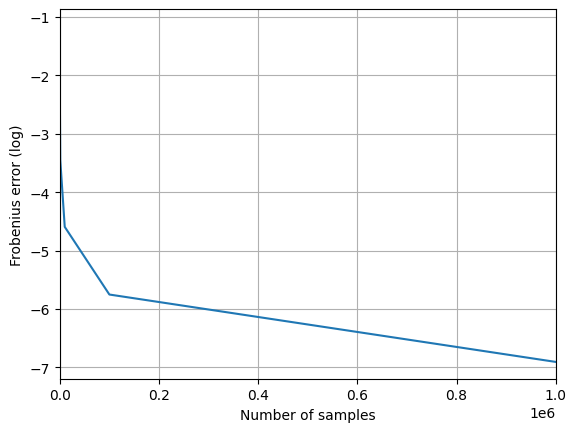

In [49]:
Ns, errors = [], []
iterator = exponential_iterator(10, 1_000_000, 10)
for n_samples in iterator:
    P_hat_n, _ = generate_tensor_sampled(P, n_samples)
    error_n = torch.norm(P - P_hat_n, p='fro')
    Ns.append(n_samples), errors.append(error_n)

plt.plot(Ns, np.log(errors))
plt.xlim(0, 1_000_000)
plt.xlabel("Number of samples")
plt.ylabel("Frobenius error (log)")
plt.grid()
plt.show()

# BCD no-masking in matrix form

In [288]:
n_iter = 20

errors = []

_, S, lmbda = generate_tensor(D, K, d)
for _ in range(n_iter):
    for mode in range(D):
        P_unfold = unfold(P_hat, mode=mode).T
        S_kr = khatri_rao(S, lmbda, skip_matrix=mode)
        S[mode] = (torch.pinverse(S_kr) @ P_unfold).T

        error = torch.norm(P_unfold - S_kr @ S[mode].T, p='fro')
        errors.append(error)

    P_unfold = P_hat.reshape((-1))
    S_kr = khatri_rao(S)
    lmbda = (torch.pinverse(S_kr) @ P_unfold)

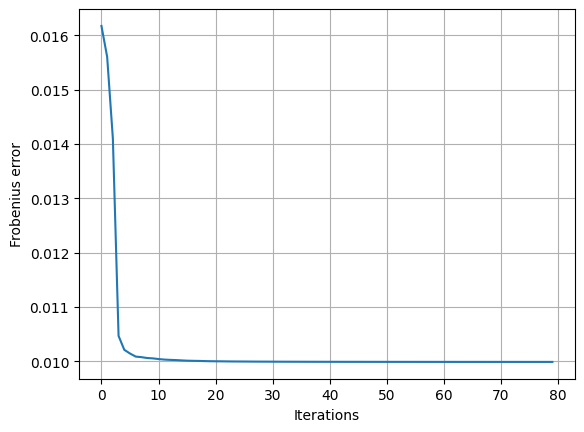

In [289]:
plt.plot(errors)
plt.xlabel("Iterations")
plt.ylabel("Frobenius error")
plt.grid()
plt.show()

# BCD no-masking vector form

In [423]:
n_iter = 20

errors = []
_, S, lmbda = generate_tensor(D, K, d)
for _ in range(n_iter):
    for mode in range(D):
        P_unfold = unfold(P_hat, mode=mode).T
        S_kr = khatri_rao(S, lmbda, skip_matrix=mode)

        I = torch.eye(d)
        S_kr = khatri_rao(S, lmbda, skip_matrix=mode)
        X = torch.kron(I, S_kr)
        y = P_unfold.T.contiguous().view(-1, 1)

        S[mode] = torch.linalg.lstsq(X, y, driver='gelsd').solution.view(S[mode].shape)

        error = torch.norm(P_unfold - S_kr @ S[mode].T, p='fro')
        errors.append(error)

    P_unfold = P_hat.reshape((-1))
    S_kr = khatri_rao(S)
    lmbda = (torch.pinverse(S_kr) @ P_unfold)

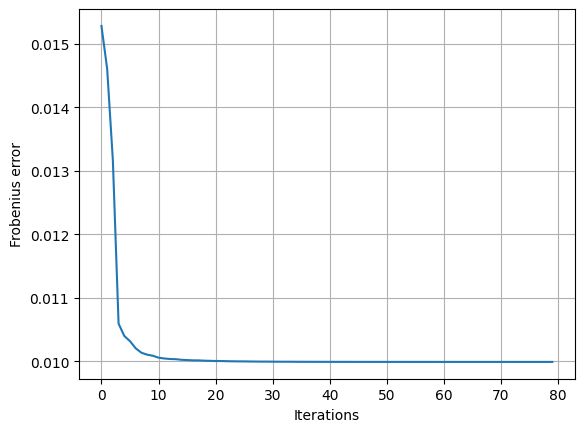

In [424]:
plt.plot(errors)
plt.xlabel("Iterations")
plt.ylabel("Frobenius error")
plt.grid()
plt.show()

# BCD masking vector form

In [436]:
n_iter = 20

errors = []
_, S, lmbda = generate_tensor(D, K, d)
for _ in range(n_iter):
    for mode in range(D):
        P_unfold = unfold(P_hat, mode=mode).T
        S_kr = khatri_rao(S, lmbda, skip_matrix=mode)

        I = torch.eye(d)
        M_unfold = torch.diag(unfold(M, mode=mode).contiguous().flatten())

        X = torch.matmul(M_unfold, torch.kron(I, S_kr))
        y = P_unfold.T.contiguous().view(-1, 1)

        s_hat = torch.linalg.lstsq(X, y, driver='gelsy').solution
        S[mode] = s_hat.view(S[mode].shape)

        error = torch.norm(y - torch.matmul(X, s_hat), p='fro')
        errors.append(error)

    P_unfold = P_hat.reshape((-1))
    M_unfold = torch.diag(M.reshape((-1)))
    S_kr = khatri_rao(S)
    lmbda = (torch.pinverse(torch.matmul(M_unfold, S_kr)) @ P_unfold)

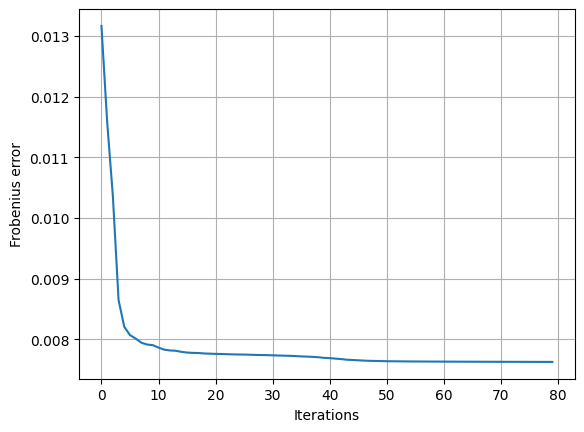

In [437]:
plt.plot(errors)
plt.xlabel("Iterations")
plt.ylabel("Frobenius error")
plt.grid()
plt.show()

# BCD masking vector form with projection

In [451]:
def project_factor(F):
    min_vals = F.min(dim=0, keepdim=True)[0]
    F_shift = F - min_vals + 1e-10

    C = F_shift.sum(dim=0, keepdim=True)
    return F_shift / C

def project_weights(lmbda):
    min_val = lmbda.min()
    lmbda_shift = lmbda - min_val + 1e-10

    C = lmbda_shift.sum()
    return lmbda_shift / C

In [454]:
n_iter = 20

errors = []
_, S, lmbda = generate_tensor(D, K, d)
for _ in range(n_iter):
    for mode in range(D):
        P_unfold = unfold(P_hat, mode=mode).T
        S_kr = khatri_rao(S, lmbda, skip_matrix=mode)

        I = torch.eye(d)
        M_unfold = torch.diag(unfold(M, mode=mode).contiguous().flatten())

        X = torch.matmul(M_unfold, torch.kron(I, S_kr))
        y = P_unfold.T.contiguous().view(-1, 1)

        s_hat = torch.linalg.lstsq(X, y, driver='gelsy').solution
        S[mode] = project_factor(s_hat.view(S[mode].shape))

        error = torch.norm(y - torch.matmul(X, s_hat), p='fro')
        errors.append(error)

    P_unfold = P_hat.reshape((-1))
    M_unfold = torch.diag(M.reshape((-1)))
    S_kr = khatri_rao(S)
    lmbda = project_weights(torch.pinverse(torch.matmul(M_unfold, S_kr)) @ P_unfold)

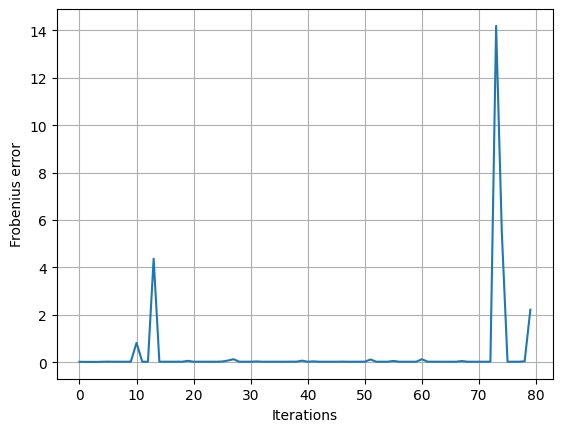

In [455]:
plt.plot(errors)
plt.xlabel("Iterations")
plt.ylabel("Frobenius error")
plt.grid()
plt.show()